# Model Report

In [1]:
import logging
from itertools import product
from time import time
from typing import Optional

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from xarray import Dataset

from speclet import model_configuration
from speclet.analysis.arviz_analysis import describe_mcmc, summarize_rhat
from speclet.bayesian_models import get_bayesian_model
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.cache_manager import (
    get_cached_posterior,
    get_posterior_cache_name,
)
from speclet.project_configuration import get_bayesian_modeling_constants
from speclet.project_enums import ModelFitMethod

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
notebook_tic = time()
set_console_handler_level(logging.WARNING)
%config InlineBackend.figure_format = "retina"
HDI_PROB = get_bayesian_modeling_constants().hdi_prob

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

## Setup

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD_STR = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
MODEL_NAME = "hnb-single-lineage-prostate"
FIT_METHOD_STR = "PYMC_NUMPYRO"
CONFIG_PATH = "models/model-configs.yaml"
ROOT_CACHE_DIR = "models"

In [5]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)
model_config = model_configuration.get_configuration_for_model(
    config_path=project_root() / CONFIG_PATH, name=MODEL_NAME
)
model = get_bayesian_model(model_config.model)(**model_config.model_kwargs)
trace = get_cached_posterior(
    get_posterior_cache_name(MODEL_NAME, FIT_METHOD),
    cache_dir=project_root() / ROOT_CACHE_DIR,
)

## Fit diagnostics

R-HAT


/home/jc604/.conda/envs/speclet_smk/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


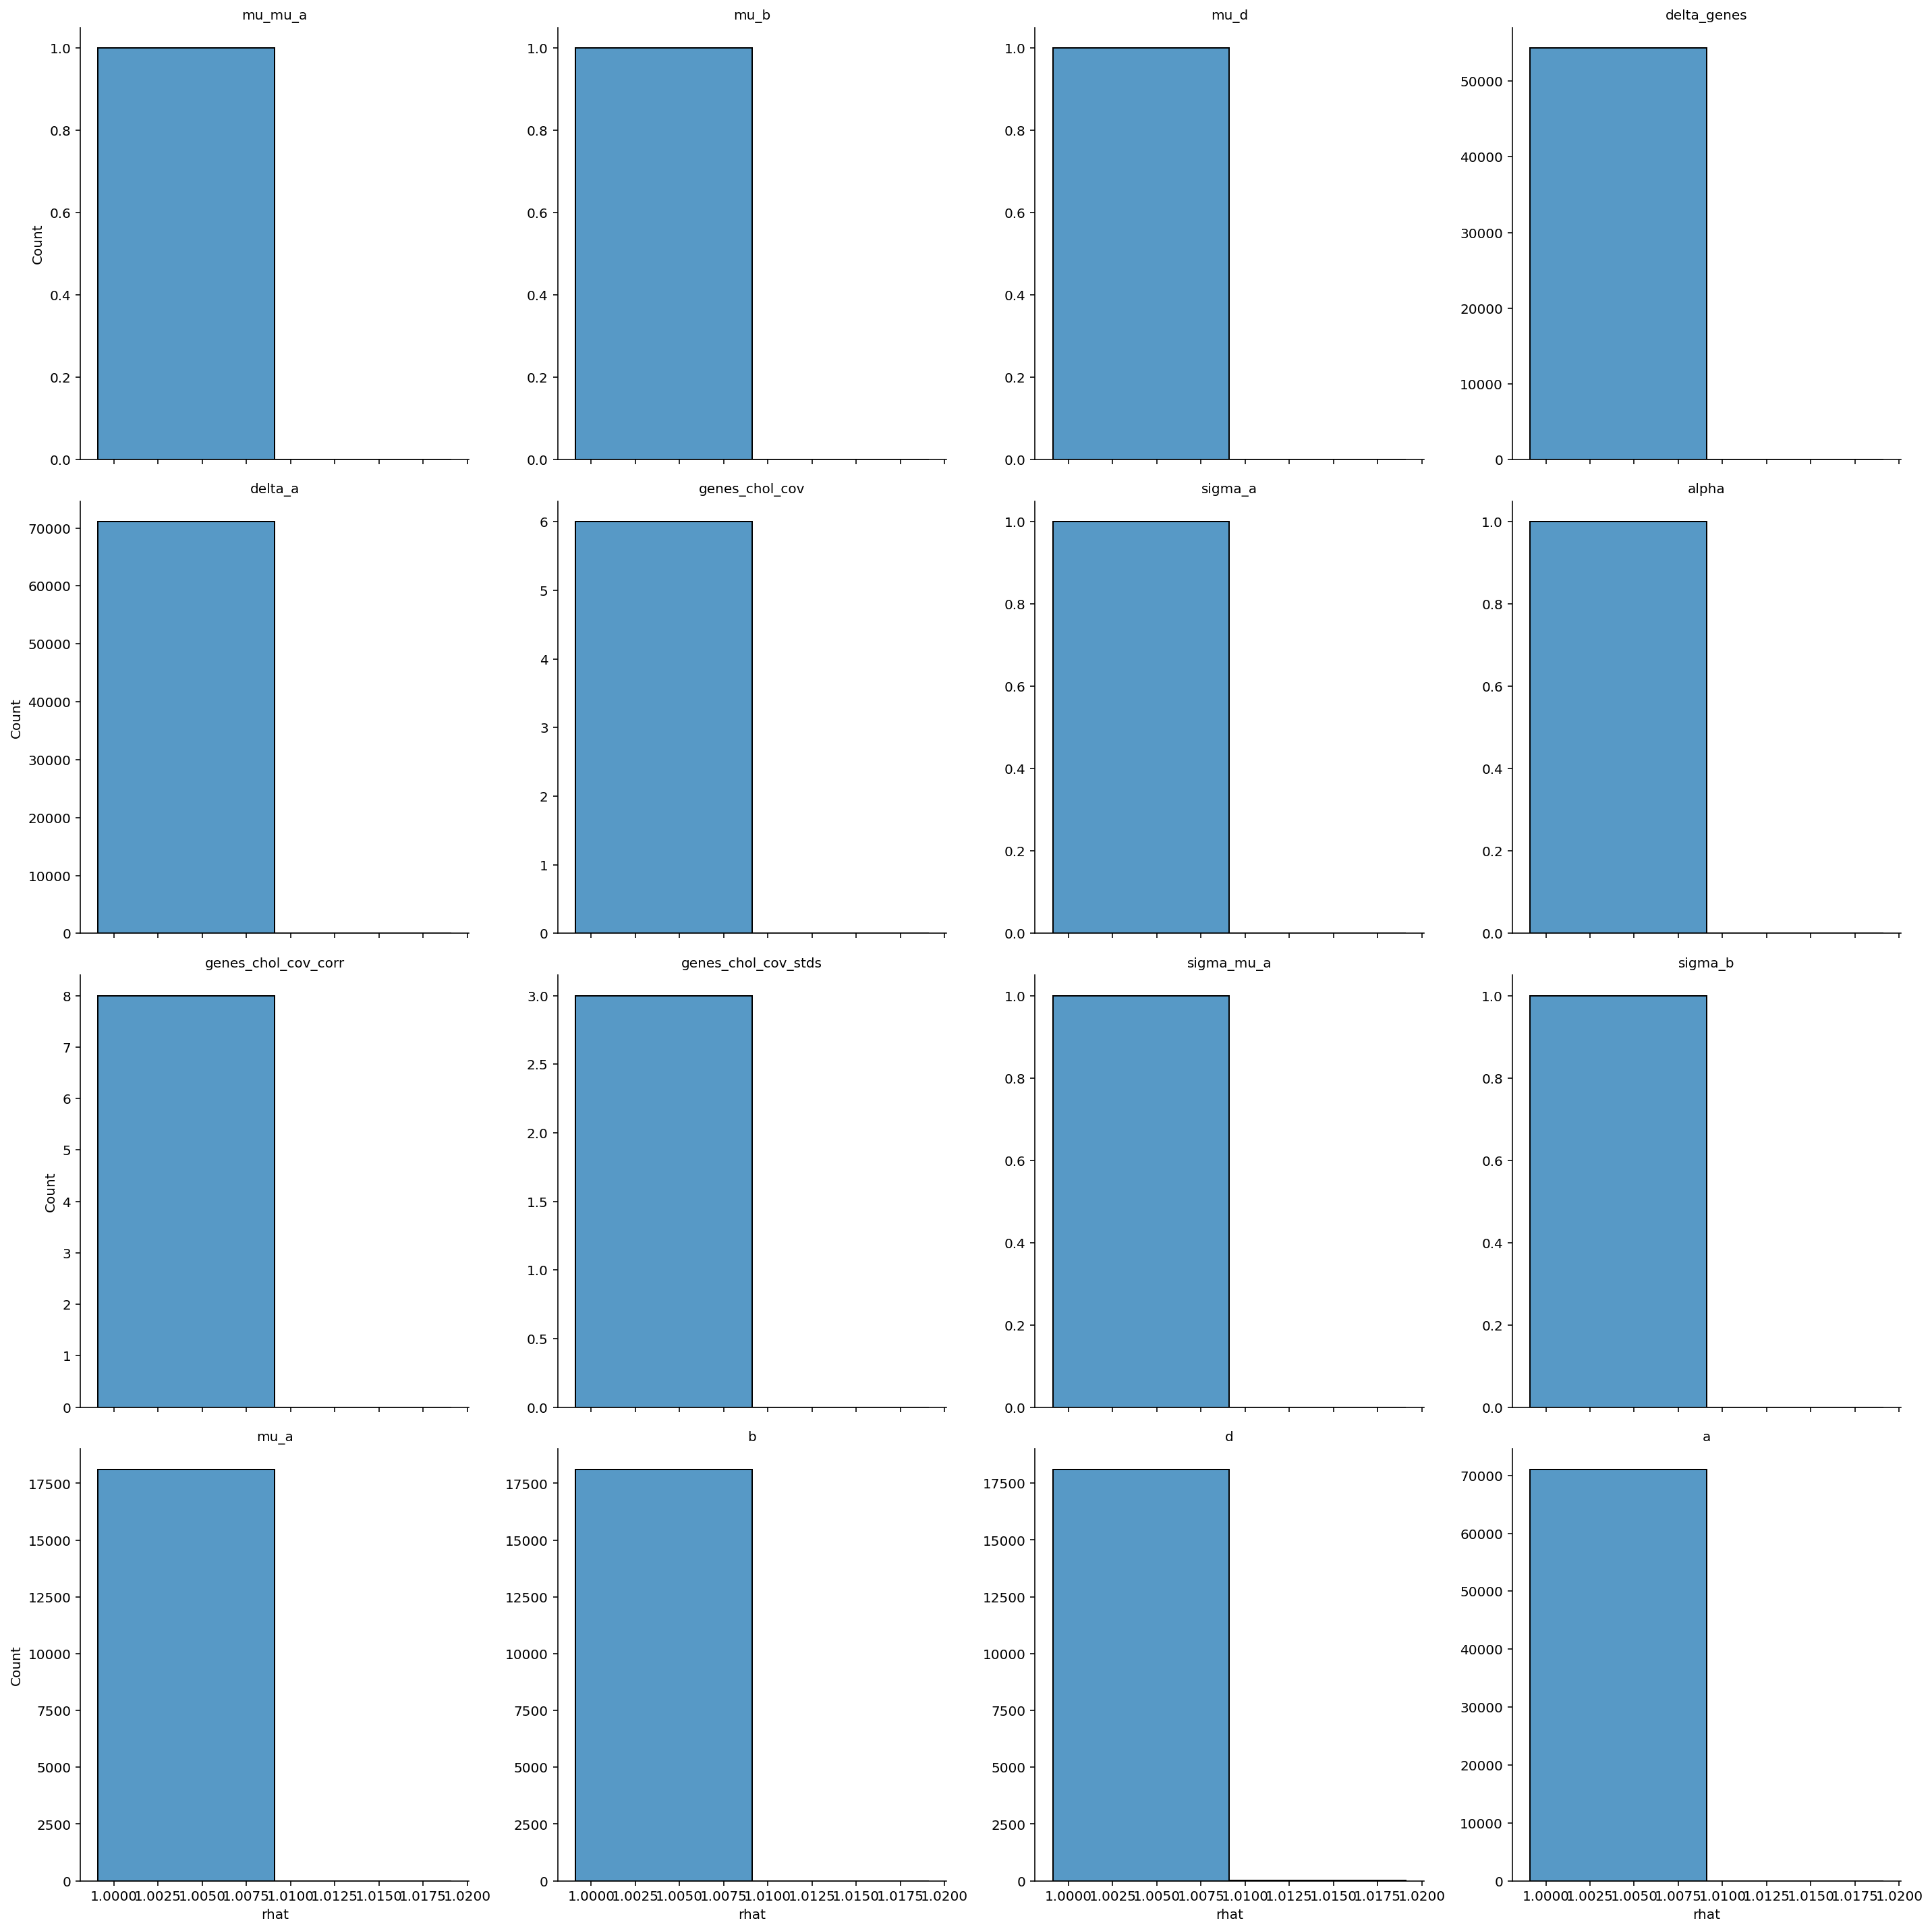

                       count      mean       std       min       25%  \
var_name                                                               
a                    71062.0  1.000777  0.000908  0.999107  1.000109   
alpha                    1.0  1.001556       NaN  1.001556  1.001556   
b                    18119.0  1.001277  0.001223  0.999169  1.000383   
d                    18119.0  1.001342  0.001277  0.999177  1.000404   
delta_a              71062.0  1.000569  0.000754  0.999116  1.000024   
delta_genes          54357.0  1.001098  0.001155  0.999163  1.000274   
genes_chol_cov           6.0  1.001309  0.001317  0.999972  1.000276   
genes_chol_cov_corr      8.0  1.000446  0.001140  0.999599  0.999684   
genes_chol_cov_stds      3.0  1.001003  0.000895  1.000242  1.000510   
mu_a                 18119.0  1.000632  0.000702  0.999226  1.000130   
mu_b                     1.0  1.000047       NaN  1.000047  1.000047   
mu_d                     1.0  0.999817       NaN  0.999817  0.99

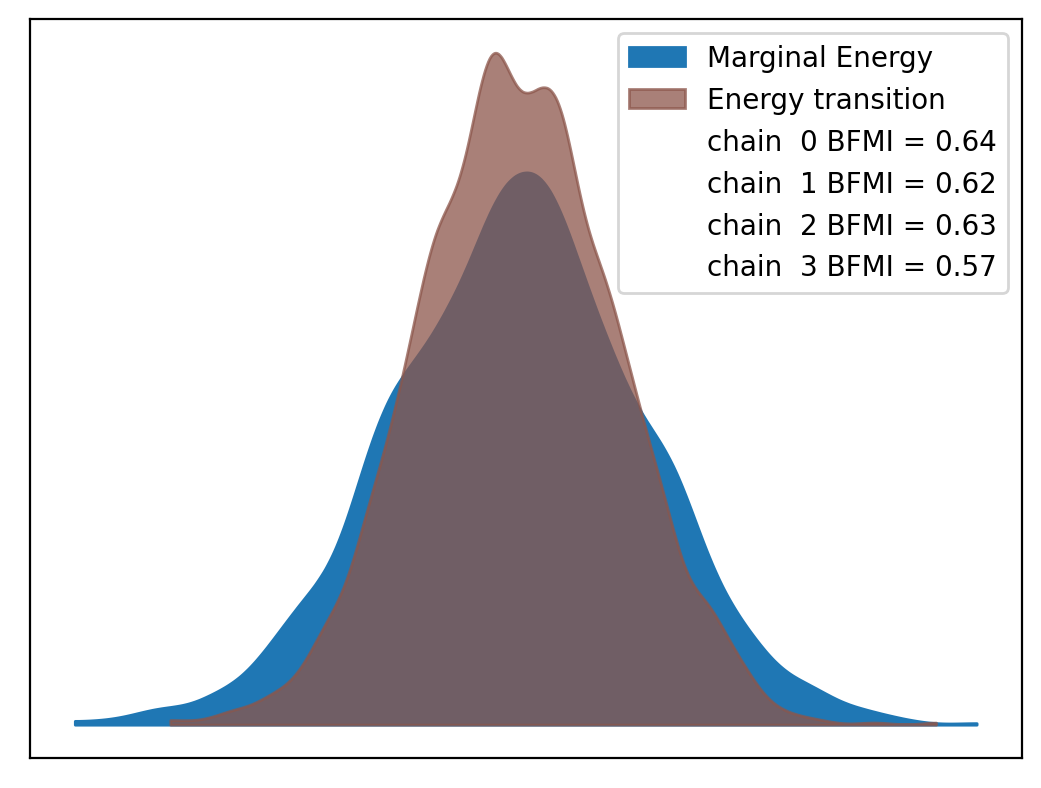

In [6]:
if FIT_METHOD in {ModelFitMethod.PYMC_NUMPYRO, ModelFitMethod.PYMC_MCMC}:
    print("R-HAT")
    rhat_summ = summarize_rhat(trace)
    print(rhat_summ)
    print("=" * 60)
    describe_mcmc(trace)

## Model predictions

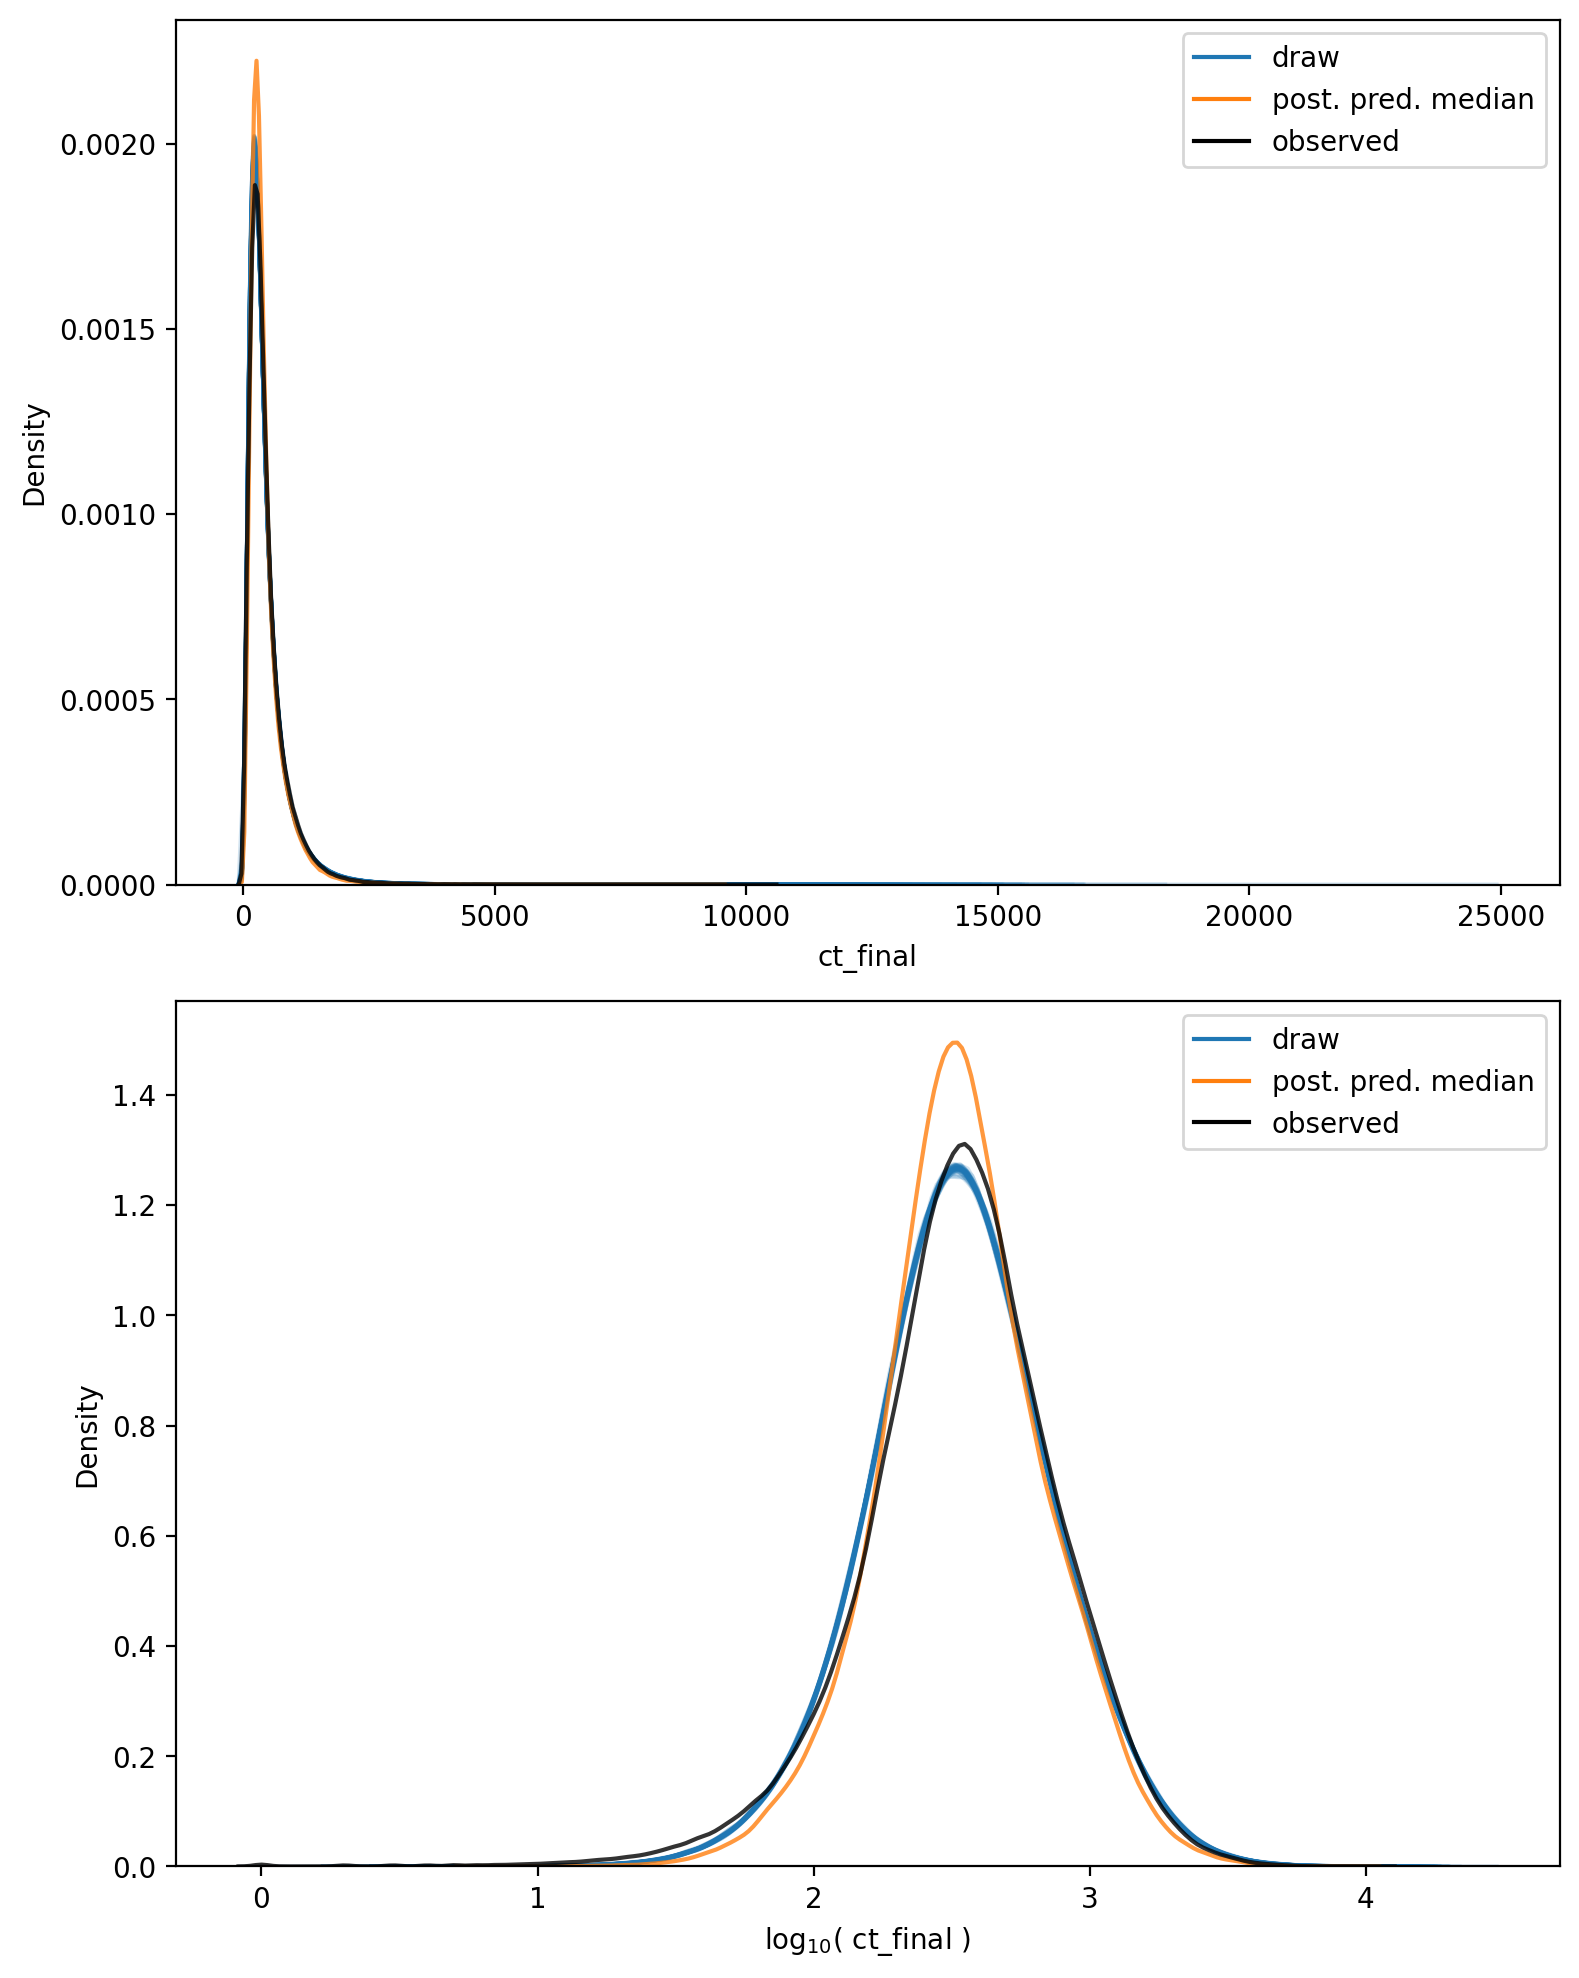

In [7]:
np.random.seed(333)

pp: Dataset = trace.posterior_predictive["ct_final"]
n_chains, n_draws, n_data = pp.shape
n_rand = 10
draws_idx = np.random.choice(np.arange(n_draws), n_rand, replace=False)

fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 10), squeeze=True, sharex=False, sharey=False
)

alpha = 0.2

for c, d in product(range(n_chains), draws_idx):
    draw = pp[c, d, :].values.flatten()
    sns.kdeplot(x=draw, ax=axes[0], color="tab:blue", alpha=alpha)
    sns.kdeplot(x=np.log10(draw + 1), ax=axes[1], color="tab:blue", alpha=alpha)

avg_ppc = pp.median(axis=(0, 1))
sns.kdeplot(x=avg_ppc, ax=axes[0], color="tab:orange", alpha=0.8)
sns.kdeplot(x=np.log10(avg_ppc + 1), ax=axes[1], color="tab:orange", alpha=0.8)

obs_data = trace.observed_data["ct_final"].values.flatten()
sns.kdeplot(x=obs_data, ax=axes[0], color="black", alpha=0.8)
sns.kdeplot(x=np.log10(obs_data + 1), ax=axes[1], color="black", alpha=0.8)

axes[0].set_xlabel("ct_final")
axes[1].set_xlabel(r"$\log_{10}($ ct_final $)$")

leg_handles = [
    Line2D([0], [0], color="tab:blue", label="draw"),
    Line2D([0], [0], color="tab:orange", label="post. pred. median"),
    Line2D([0], [0], color="black", label="observed"),
]
for ax in axes:
    ax.legend(handles=leg_handles, loc="best")

plt.tight_layout()
plt.show()

In [8]:
has_log_likelihood = "log_likelihood" in trace

In [9]:
if has_log_likelihood:
    psis_loo = az.loo(trace, pointwise=True)
    psis_loo

In [10]:
if has_log_likelihood:
    az.plot_khat(psis_loo)
    plt.tight_layout()
    plt.show()

---

In [11]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 15.10 minutes


In [12]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-24

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.66.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Hostname: compute-f-17-14.o2.rc.hms.harvard.edu

Git branch: simplify

arviz     : 0.12.1
logging   : 0.5.1.2
matplotlib: 3.5.2
numpy     : 1.23.0
speclet   : 0.0.9000
seaborn   : 0.11.2

